# Modelo datos estructurados

Este notebook desarrolla un modelo para resolver el problema de Petfinder. El proceso incluye los siguientes pasos:

1. Realizamos Feature Engineering para preparar y optimizar nuestras variables.
2. Desarrollamos un modelo inicial para evaluar la viabilidad de resolver el problema utilizando los datos tabulares.
3. Analizamos el comportamiento de la métrica kappa propuesta y examinamos la matriz de confusión.
4. Llevamos a cabo una optimización de hiperparámetros utilizando dos enfoques:
   - Evaluación con train/test
   - Validación con 5-fold CV y prueba en el 20% de los datos

Este enfoque nos permitirá construir un modelo basado en datos tabulares y evaluar su rendimiento de cara a las futuras etapas.

## Importamos librerias

In [120]:
#Import de librerias basicas tablas y matrices
import numpy as np 
import pandas as pd 

#Gradient Boosting
import lightgbm as lgb

#Funciones auxiliares sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold #Split y cross Validation
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score #Metricas
from sklearn.preprocessing import OneHotEncoder

# from sklearn.utils import shuffle 

#Visualizacióon
from plotly import express as px

#Plot de matriz de confusion normalizada en actuals
from utils import plot_confusion_matrix

import os

#Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

#Guardado de objetos en archivos joblib
from joblib import load, dump


#Graficos y otras
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap


## Estructura de archivos
Esto es de suma importancia para que el procedimineto se lleve adelante de manera adecuada

In [122]:
# Paths para acceso archivos
#Este notebook asume la siguiente estructura de carpetas a partir de la ubicacion de base_dir 
#(dos niveles arriba de la carpeta donde se ejecuta el notebook). 
# /UA_MDM_LDI_II/
# /UA_MDM_LDI_II/input
# /UA_MDM_LDI_II/input/petfinder-adoption-prediction/            <- Aca deben ir todos los archivos de datos de la competencia 
# /UA_MDM_LDI_II/tutoriales/                       <- Aca deben poner los notebooks y scripts que les compartimos
# /UA_MDM_LDI_II/work/                             <- Resultados de notebooks iran dentro de esta carpeta en subcarpetas
# /UA_MDM_LDI_II/work/models/                     <- Modelos entrenados en archivos joblibs
# /UA_MDM_LDI_II/work/optuna_temp_artifacts/      <- Archivos que queremos dejar como artefacto de un trial de optuna (optuna los copiara a la carpeta de abajo)
# /UA_MDM_LDI_II/work/optuna_artifacts/           <- Archivos con artefactos que sibimos a optuna

#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_LDI_II
BASE_DIR = '../'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")


SEED = 42 #Semilla de procesos aleatorios (para poder replicar exactamente al volver a correr un modelo)
TEST_SIZE = 0.2 #Facción para train/test= split 

#PONER CUALQUIER SEMILLLA Y 20% DEL DATASTE USAMOS

## Lectura del dataset
Lectura del dataset tabular y primeros analisis de los datos

In [124]:
# Datos Tabulares
dataset = pd.read_csv(PATH_TO_TRAIN)

In [125]:
#Columnas del dataset
dataset.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [126]:
dataset.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


## FEATURE ENGINEERING

En esta sección, nos enfocaremos en el proceso de Feature Engineering. Este paso implica la creación, modificación y selección de características (features) en nuestro conjunto de datos con el objetivo de:

1. Mejorar el rendimiento predictivo de nuestro modelo.
2. Extraer información más relevante de los datos existentes.
3. Crear nuevas variables que capturen relaciones importantes no evidentes en los datos.

Evaluaremos el impacto de estas modificaciones comparando el rendimiento del modelo con y sin las nuevas características para evaluar de esta forma cuanto aporta el FE a la mejora final del modelo.

In [127]:
#Imputar datos faltantes en Nombre
dataset.isnull().sum()

Type                0
Name             1265
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        13
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

In [128]:
def feature_engineering(dataset):
    # Categorizacion de la edad
    bins = [0, 12, 60, float('inf')]
    labels = [1, 2, 3]  # 1='puppy' 2='adult' 3='senior'
    dataset['AgeCategory'] = pd.cut(dataset['Age'], bins, labels=labels, right=False) #Categoriza la edad en 3 grupos

    # Combinacion de raza
    dataset['Breed'] = dataset.apply(lambda row: 2 if row['Breed2'] != 0 else 1, axis=1)#Crea una variable que indica si la mascota es de raza pura o no

    # Color
    dataset['IsMultiColored'] = dataset.apply(lambda row: 1 if row['Color2'] != 0 or row['Color3'] != 0 else 0, axis=1)

    # Nombre
    dataset['Name'].fillna('No Name Yet', inplace=True) # Rellenar valores faltantes
    dataset['Name'] = dataset['Name'].replace('', 'No Name Yet') # Rellenar valores vacios
    dataset['Name'] = dataset['Name'].apply(lambda x: 'No Name Yet' if len(str(x)) < 3 else x) # Tratar nombres con 2 caracteres o menos como sin nombre
    dataset['name_code'] = dataset['Name'].apply(lambda x: 1 if x != 'No Name Yet' else 0) # Variable que indica si la mascota tiene nombre
    dataset['Is_Genuine_Name'] = ((dataset['Name'] != 'No Name Yet') & (dataset['Quantity'] > 1)).astype(int) # Variable que indica si el nombre es genuino teniendo en cuenta la cantidad de mascotas asociadas a un solo nombre
    
    # logaritmo a variables numericas puede ayudar a normalizar las distribuciones
    dataset['Age_log'] = np.log1p(dataset['Age']) 
    dataset['PhotoAmt_log'] = np.log1p(dataset['PhotoAmt'])
    dataset['VideoAmt_log'] = np.log1p(dataset['VideoAmt'])
    dataset['Fee_log'] = np.log1p(dataset['Fee'])

    # intersecciones y agregaciones por genero
    dataset['Gender_Age_mean'] = dataset.groupby('Gender')['Age'].transform('mean') # Edad promedio por genero
    dataset['Gender_Fee_mean'] = dataset.groupby('Gender')['Fee'].transform('mean') # Tarifa promedio por genero
    dataset['Gender_PhotoAmt_mean'] = dataset.groupby('Gender')['PhotoAmt'].transform('mean') # Cantidad de fotos promedio por genero
    dataset['Gender_VideoAmt_mean'] = dataset.groupby('Gender')['VideoAmt'].transform('mean') # Cantidad de videos promedio por genero

    # intersecciones y agregaciones por raza (Breed1 indicando la raza principal)
    dataset['Breed_Age_mean'] = dataset.groupby('Breed1')['Age'].transform('mean') # Edad promedio por raza
    dataset['Breed_Fee_mean'] = dataset.groupby('Breed1')['Fee'].transform('mean') # Tarifa promedio por raza
    dataset['Breed_PhotoAmt_mean'] = dataset.groupby('Breed1')['PhotoAmt'].transform('mean') # Cantidad de fotos promedio por raza
    dataset['Breed_VideoAmt_mean'] = dataset.groupby('Breed1')['VideoAmt'].transform('mean') # Cantidad de videos promedio por raza 
    
    # intersecciones y agregaciones por genero y raza
    dataset['Gender_Breed_Age_mean'] = dataset.groupby(['Gender', 'Breed1'])['Age'].transform('mean') # Edad promedio por genero y raza
    dataset['Gender_Breed_Fee_mean'] = dataset.groupby(['Gender', 'Breed1'])['Fee'].transform('mean') # Tarifa promedio por genero y raza
    dataset['Gender_Breed_PhotoAmt_mean'] = dataset.groupby(['Gender', 'Breed1'])['PhotoAmt'].transform('mean') # Cantidad de fotos promedio por genero y raza
    dataset['Gender_Breed_VideoAmt_mean'] = dataset.groupby(['Gender', 'Breed1'])['VideoAmt'].transform('mean') # Cantidad de videos promedio por genero y raza
    
    # Ratios o diferencias entre variables
    dataset['Age_to_Gender_mean_ratio'] = dataset['Age'] / dataset['Gender_Age_mean'] # Razon entre la edad de la mascota y la edad promedio por genero
    dataset['Fee_to_Gender_mean_ratio'] = dataset['Fee'] / dataset['Gender_Fee_mean'] # Razon entre la tarifa de la mascota y la tarifa promedio por genero
    dataset['Age_to_Breed_mean_ratio'] = dataset['Age'] / dataset['Breed_Age_mean'] # Razon entre la edad de la mascota y la edad promedio por raza
    dataset['Fee_to_Breed_mean_ratio'] = dataset['Fee'] / dataset['Breed_Fee_mean'] # Razon entre la tarifa de la mascota y la tarifa promedio por raza
    
    # Interacciones entre variables
    dataset['Age_Fee_interaction'] = dataset['Age'] * dataset['Fee'] # Interaccion entre la edad y la tarifa
    dataset['PhotoAmt_VideoAmt_interaction'] = dataset['PhotoAmt'] * dataset['VideoAmt'] # Interaccion entre la cantidad de fotos y videos
    
    # logaritmo de nuevas variables
    dataset['Gender_Fee_mean_log'] = np.log1p(dataset['Gender_Fee_mean'])
    dataset['Breed_Fee_mean_log'] = np.log1p(dataset['Breed_Fee_mean'])
    dataset['Gender_Breed_Fee_mean_log'] = np.log1p(dataset['Gender_Breed_Fee_mean'])
    
    # intereaciones adicionales
    dataset['Age_PhotoAmt_Fee_interaction'] = dataset['Age'] * dataset['PhotoAmt'] * dataset['Fee']
    dataset['Age_VideoAmt_Fee_interaction'] = dataset['Age'] * dataset['VideoAmt'] * dataset['Fee']

    # Interacciones entre variables
    dataset['Age_PhotoAmt'] = dataset['Age'] * dataset['PhotoAmt'] # Interaccion entre la edad y la cantidad de fotos
    dataset['Age_VideoAmt'] = dataset['Age'] * dataset['VideoAmt'] # Interaccion entre la edad y la cantidad de videos
    dataset['Photo_Video_Ratio'] = dataset['PhotoAmt'] / (dataset['VideoAmt'] + 1) # Ratio entre PhotoAmt y VideoAmt
    dataset['Fee_Age_Ratio'] = dataset['Fee'] / (dataset['Age'] + 1) # Ratio entre Fee y Age
    dataset['MaturitySize_FurLength'] = dataset['MaturitySize'] * dataset['FurLength'] #interacion entre MaturitySize y FurLength
    dataset['PhotoAmt_FurLength'] = dataset['PhotoAmt'] * dataset['FurLength'] # interaccion entre PhotoAmt y FurLength
    dataset['VideoAmt_FurLength'] = dataset['VideoAmt'] * dataset['FurLength'] # interaccion entre VideoAmt y FurLength
    
    # mas agregaciones
    dataset['Breed1_mean_Age'] = dataset.groupby('Breed1')['Age'].transform('mean') # Edad promedio por raza
    dataset['Breed1_mean_PhotoAmt'] = dataset.groupby('Breed1')['PhotoAmt'].transform('mean') # Cantidad de fotos promedio por raza
    dataset['RescuerID_count'] = dataset.groupby('RescuerID')['RescuerID'].transform('count') # Cantidad de mascotas por RescuerID

    # Nuevas variables asociadas al texto
    dataset["description_word_count"] = dataset["Description"].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0) # Cantidad de palabras en la descripcion
    dataset['Description_Length'] = dataset['Description'].apply(lambda x: len(x) if isinstance(x, str) else 0) # Longitud de la descripcion
    dataset['Name_Length'] = dataset['Name'].apply(len) # Longitud del nombre
    dataset['Name_Word_Count'] = dataset['Name'].apply(lambda x: len(x.split())) # Cantidad de palabras en el nombre
    dataset['Name_Length_Category'] = dataset['Name'].apply(lambda x: 0 if len(x) < 5 else 1) # Categorizacion de la longitud del nombre

    # SALUD:
    # condicion simple
    dataset['Health_vac'] = np.where(dataset['Vaccinated'] == 1, 1, 0)
    dataset['Health_dew'] = np.where(dataset['Dewormed'] == 1, 1, 0)
    dataset['Health_ster'] = np.where(dataset['Sterilized'] == 1, 1, 0)
    # condiciones dobles
    dataset['Health_vac_dew'] = np.where((dataset['Vaccinated'] == 1) & (dataset['Dewormed'] == 1), 1, 0)
    dataset['Health_vac_ster'] = np.where((dataset['Vaccinated'] == 1) & (dataset['Sterilized'] == 1), 1, 0)
    dataset['Health_dew_ster'] = np.where((dataset['Dewormed'] == 1) & (dataset['Sterilized'] == 1), 1, 0)
    # Todas las combinaciones (salud completa)
    dataset['Health_full'] = np.where((dataset['Vaccinated'] == 1) & (dataset['Dewormed'] == 1) & (dataset['Sterilized'] == 1), 1, 0)
    # Condicion simple inversa 
    dataset['Health_not_vac'] = np.where(dataset['Vaccinated'] == 2, 1, 0)
    dataset['Health_not_dew'] = np.where(dataset['Dewormed'] == 2, 1, 0)
    dataset['Health_not_ster'] = np.where(dataset['Sterilized'] == 2, 1, 0)
    # Condiciones dobles inversas
    dataset['Health_not_vac_dew'] = np.where((dataset['Vaccinated'] == 2) & (dataset['Dewormed'] == 2), 1, 0)
    dataset['Health_not_vac_ster'] = np.where((dataset['Vaccinated'] == 2) & (dataset['Sterilized'] == 2), 1, 0)
    dataset['Health_not_dew_ster'] = np.where((dataset['Dewormed'] == 2) & (dataset['Sterilized'] == 2), 1, 0)
    # Todas las combinaciones inversas (salud nula)
    dataset['Health_none'] = np.where((dataset['Vaccinated'] == 2) & (dataset['Dewormed'] == 2) & (dataset['Sterilized'] == 2), 1, 0)
    
    # FE adicionales asociados a rescuerID
    dataset['RescuerID_mean_Age'] = dataset.groupby('RescuerID')['Age'].transform('mean')# Promedio de edades de mascotas para cada rescatista
    dataset['RescuerID_std_Age'] = dataset.groupby('RescuerID')['Age'].transform('std')# Desviacion estandar de edades de mascotas para cada rescatista
    dataset['RescuerID_mean_Fee'] = dataset.groupby('RescuerID')['Fee'].transform('mean')# Promedio de tarifas para cada rescatista
    dataset['RescuerID_std_Fee'] = dataset.groupby('RescuerID')['Fee'].transform('std')# Desviacion estandar de tarifas para cada rescatista
    dataset['RescuerID_mean_PhotoAmt'] = dataset.groupby('RescuerID')['PhotoAmt'].transform('mean')# Promedio de fotos por mascota para cada rescatista
    dataset['RescuerID_mean_VideoAmt'] = dataset.groupby('RescuerID')['VideoAmt'].transform('mean')# Promedio de videos por mascota para cada rescatista
    dataset['RescuerID_name_ratio'] = dataset.groupby('RescuerID')['name_code'].transform('mean')# Porcentaje de mascotas con nombre para cada rescatista
    dataset['RescuerID_most_common_breed'] = dataset.groupby('RescuerID')['Breed1'].transform(lambda x: x.value_counts().index[0])# Raza mas comun para cada rescatista
    dataset['RescuerID_young_ratio'] = dataset.groupby('RescuerID')['AgeCategory'].transform(lambda x: (x == 1).mean())# Porcentaje de mascotas cachorras para cada rescatista
    dataset['RescuerID_full_health_ratio'] = dataset.groupby('RescuerID')['Health_full'].transform('mean')# Porcentaje de mascotas con salud completa (vacunado, desparasitado y esterilizado) para cada rescatista
    dataset['RescuerID_mean_description_length'] = dataset.groupby('RescuerID')['Description_Length'].transform('mean')# Longitud promedio de descripciones para cada rescatista
    dataset['RescuerID_dog_ratio'] = dataset.groupby('RescuerID')['Type'].transform(lambda x: (x == 1).mean()) #Perro vs gato ratio para cada rescatista
    dataset['RescuerID_breed_specialization'] = dataset.groupby('RescuerID')['Breed1'].transform(lambda x: x.value_counts().iloc[0] / len(x)) # Especializacion en raza para cada rescatista
    
    return dataset

In [129]:
feature_engineering(dataset)
dataset.head()

C:\Users\Miner\AppData\Local\Temp\ipykernel_2764\2023535862.py:15: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RescuerID_std_Fee,RescuerID_mean_PhotoAmt,RescuerID_mean_VideoAmt,RescuerID_name_ratio,RescuerID_most_common_breed,RescuerID_young_ratio,RescuerID_full_health_ratio,RescuerID_mean_description_length,RescuerID_dog_ratio,RescuerID_breed_specialization
0,2,Nibble,3,299,0,1,1,7,0,1,...,51.754917,1.500000,0.000000,1.000000,276,0.750000,0.000000,434.250000,0.000000,0.375000
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,NaN,2.000000,0.000000,0.000000,265,1.000000,0.000000,118.000000,0.000000,1.000000
2,1,Brisco,1,307,0,1,2,7,0,2,...,14.927688,3.572985,0.010893,0.986928,307,0.941176,0.106754,174.178649,0.991285,0.684096
3,1,Miko,4,307,0,2,1,2,0,2,...,70.101967,9.500000,0.020000,1.000000,307,0.820000,0.280000,426.180000,0.820000,0.760000
4,1,Hunter,1,307,0,1,1,0,0,2,...,0.000000,2.305970,0.007463,1.000000,307,0.895522,0.044776,242.029851,0.970149,0.895522


In [130]:
# Listar variables numéricas
numeric_features = dataset.select_dtypes(include=['number']).columns.tolist()
print("Variables numéricas:", numeric_features)

# Listar variables categóricas
categorical_features = dataset.select_dtypes(include=['object', 'category']).columns.tolist()
print("Variables categóricas:", categorical_features)

Variables numéricas: ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt', 'AdoptionSpeed', 'Breed', 'IsMultiColored', 'name_code', 'Is_Genuine_Name', 'Age_log', 'PhotoAmt_log', 'VideoAmt_log', 'Fee_log', 'Gender_Age_mean', 'Gender_Fee_mean', 'Gender_PhotoAmt_mean', 'Gender_VideoAmt_mean', 'Breed_Age_mean', 'Breed_Fee_mean', 'Breed_PhotoAmt_mean', 'Breed_VideoAmt_mean', 'Gender_Breed_Age_mean', 'Gender_Breed_Fee_mean', 'Gender_Breed_PhotoAmt_mean', 'Gender_Breed_VideoAmt_mean', 'Age_to_Gender_mean_ratio', 'Fee_to_Gender_mean_ratio', 'Age_to_Breed_mean_ratio', 'Fee_to_Breed_mean_ratio', 'Age_Fee_interaction', 'PhotoAmt_VideoAmt_interaction', 'Gender_Fee_mean_log', 'Breed_Fee_mean_log', 'Gender_Breed_Fee_mean_log', 'Age_PhotoAmt_Fee_interaction', 'Age_VideoAmt_Fee_interaction', 'Age_PhotoAmt', 'Age_VideoAmt', 'Photo_Video_Ratio', 'Fee_Ag

In [131]:
#Este fragmento de código define una función add_new_variables_with_lgbm que agrega nuevas variables a un conjunto de datos utilizando un modelo de LightGBM. Aquí está el desglose paso a paso:
#En principio descartamos esta funcion ya que la misma produce un overfitting en el modelo
def add_new_variables_with_lgbm(dataset):
    # Selección de características numéricas y categóricas:
    numeric_features = ['Age', 'VideoAmt', 'PhotoAmt', 'AgeCategory', 'IsMultiColored', 'name_code','Age_log', 'PhotoAmt_log', 'VideoAmt_log', 'Age_PhotoAmt', 'Age_VideoAmt', 'Breed1_mean_Age', 'Breed1_mean_PhotoAmt']
    categorical_features = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3']

    # Codificación de características categóricas:
    encoded_features = pd.get_dummies(dataset[categorical_features], columns=categorical_features, prefix=categorical_features)

    # Concatenación de características numéricas y codificadas:
    processed_dataset = pd.concat([dataset[numeric_features], encoded_features], axis=1)

    # Creación del conjunto de datos de entrenamiento:
    target = dataset['AdoptionSpeed']
    train_data = lgb.Dataset(processed_dataset, label=target, params={'verbose': -1})

    # Definición de parámetros de LightGBM
    lgb_params = {
        'objective': 'multiclass',
        'num_class': 5,  
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
    }

    # Entrenamiento del modelo LightGBM:
    model = lgb.train(lgb_params, train_data)

    # Obtención de predicciones para cada muestra:
    predictions = model.predict(processed_dataset)

    # Adición de nuevas variables basadas en las predicciones:
    for class_num in range(5):  
        dataset[f'prediction_class_{class_num}'] = predictions[:, class_num]

    return dataset

# Llamada a la función con el DataFrame:
df_with_new_variables = add_new_variables_with_lgbm(dataset.copy())  # Usar dataset.copy() para evitar modificar el DataFrame original

In [132]:
df_with_new_variables

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RescuerID_young_ratio,RescuerID_full_health_ratio,RescuerID_mean_description_length,RescuerID_dog_ratio,RescuerID_breed_specialization,prediction_class_0,prediction_class_1,prediction_class_2,prediction_class_3,prediction_class_4
0,2,Nibble,3,299,0,1,1,7,0,1,...,0.750000,0.000000,434.250000,0.000000,0.375000,0.031812,0.266726,0.309360,0.192574,0.199528
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1.000000,0.000000,118.000000,0.000000,1.000000,0.107394,0.302479,0.279231,0.129347,0.181548
2,1,Brisco,1,307,0,1,2,7,0,2,...,0.941176,0.106754,174.178649,0.991285,0.684096,0.010582,0.239320,0.369112,0.320883,0.060103
3,1,Miko,4,307,0,2,1,2,0,2,...,0.820000,0.280000,426.180000,0.820000,0.760000,0.002984,0.088127,0.219885,0.391229,0.297774
4,1,Hunter,1,307,0,1,1,0,0,2,...,0.895522,0.044776,242.029851,0.970149,0.895522,0.005832,0.352999,0.347447,0.198967,0.094755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,No Name Yet,2,266,0,3,1,0,0,2,...,1.000000,0.000000,396.500000,0.000000,0.500000,0.008049,0.256520,0.238949,0.222162,0.274319
14989,2,Serato & Eddie,60,265,264,3,1,4,7,2,...,0.000000,1.000000,142.000000,0.000000,0.666667,0.001065,0.057035,0.256470,0.193212,0.492219
14990,2,Monkies,2,265,266,3,5,6,7,3,...,0.578947,0.526316,211.210526,0.263158,0.315789,0.020654,0.374353,0.228038,0.208278,0.168676
14991,2,Ms Daym,9,266,0,2,4,7,0,1,...,1.000000,0.200000,266.800000,0.000000,0.600000,0.018798,0.117444,0.133822,0.187787,0.542149


In [133]:
#finalmente renombramos el dataset para seguir adelante con el modelado
dataset=df_with_new_variables

## Modelado con LightGBM

A continuación, se detallan los pasos para implementar un modelo LightGBM (Light Gradient Boosting Machine).

### Pasos del proceso:

1. **Preparación de datos**
   - División del conjunto de datos en entrenamiento y prueba
   - Definición de características (features) y variable objetivo

2. **Configuración inicial del modelo**
   - Establecimiento de hiperparámetros base
   - Creación del conjunto de datos LightGBM

3. **Entrenamiento del modelo base**
   - Ajuste del modelo con los parámetros iniciales
   - Evaluación preliminar del rendimiento

4. **Optimización de hiperparámetros**
   - Implementación de búsqueda de hiperparámetros (Bayesiana)
   - Validación cruzada para evaluar la robustez del modelo

5. **Entrenamiento del modelo final**
   - Ajuste del modelo con los hiperparámetros optimizados
   - Evaluación en el conjunto de prueba

6. **Análisis de resultados**
   - Métricas de rendimiento (Kappa)
   - Importancia de características



In [134]:

#Separo un 20% para test estratificado por target manteniendo su proporcion
train, test = train_test_split(dataset,
                               test_size = TEST_SIZE,
                               random_state = SEED,
                               stratify = dataset.AdoptionSpeed)

In [135]:
#Armo listas con features de texto y numericas
char_feats = [f for f in dataset.columns if dataset[f].dtype=='O']
numeric_feats = [f for f in dataset.columns if dataset[f].dtype!='O']

In [136]:
#Lista de features numericas
numeric_feats

['Type',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'VideoAmt',
 'PhotoAmt',
 'AdoptionSpeed',
 'AgeCategory',
 'Breed',
 'IsMultiColored',
 'name_code',
 'Is_Genuine_Name',
 'Age_log',
 'PhotoAmt_log',
 'VideoAmt_log',
 'Fee_log',
 'Gender_Age_mean',
 'Gender_Fee_mean',
 'Gender_PhotoAmt_mean',
 'Gender_VideoAmt_mean',
 'Breed_Age_mean',
 'Breed_Fee_mean',
 'Breed_PhotoAmt_mean',
 'Breed_VideoAmt_mean',
 'Gender_Breed_Age_mean',
 'Gender_Breed_Fee_mean',
 'Gender_Breed_PhotoAmt_mean',
 'Gender_Breed_VideoAmt_mean',
 'Age_to_Gender_mean_ratio',
 'Fee_to_Gender_mean_ratio',
 'Age_to_Breed_mean_ratio',
 'Fee_to_Breed_mean_ratio',
 'Age_Fee_interaction',
 'PhotoAmt_VideoAmt_interaction',
 'Gender_Fee_mean_log',
 'Breed_Fee_mean_log',
 'Gender_Breed_Fee_mean_log',
 'Age_PhotoAmt_Fee_interaction',
 'Age_VideoAmt_Fee_interaction',
 'Age_PhotoAmt'

In [137]:

#Defino features a usar en un primer modelo de prueba
features = ['Type',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'VideoAmt',
 'PhotoAmt',
 #'AdoptionSpeed', #variable target
 'AgeCategory',
 'Breed',
 'IsMultiColored',
 'name_code',
 'Is_Genuine_Name',
 'Age_log',
 'PhotoAmt_log',
 'VideoAmt_log',
 'Fee_log',
 'Gender_Age_mean',
 'Gender_Fee_mean',
 'Gender_PhotoAmt_mean',
 'Gender_VideoAmt_mean',
 'Breed_Age_mean',
 'Breed_Fee_mean',
 'Breed_PhotoAmt_mean',
 'Breed_VideoAmt_mean',
 'Gender_Breed_Age_mean',
 'Gender_Breed_Fee_mean',
 'Gender_Breed_PhotoAmt_mean',
 'Gender_Breed_VideoAmt_mean',
 'Age_to_Gender_mean_ratio',
 'Fee_to_Gender_mean_ratio',
 'Age_to_Breed_mean_ratio',
 'Fee_to_Breed_mean_ratio',
 'Age_Fee_interaction',
 'PhotoAmt_VideoAmt_interaction',
 'Gender_Fee_mean_log',
 'Breed_Fee_mean_log',
 'Gender_Breed_Fee_mean_log',
 'Age_PhotoAmt_Fee_interaction',
 'Age_VideoAmt_Fee_interaction',
 'Age_PhotoAmt',
 'Age_VideoAmt',
 'Photo_Video_Ratio',
 'Fee_Age_Ratio',
 'MaturitySize_FurLength',
 'PhotoAmt_FurLength',
 'VideoAmt_FurLength',
 'Breed1_mean_Age',
 'Breed1_mean_PhotoAmt',
 'RescuerID_count',
 'description_word_count',
 'Description_Length',
 'Name_Length',
 'Name_Word_Count',
 'Name_Length_Category',
 'Health_vac',
 'Health_dew',
 'Health_ster',
 'Health_vac_dew',
 'Health_vac_ster',
 'Health_dew_ster',
 'Health_full',
 'Health_not_vac',
 'Health_not_dew',
 'Health_not_ster',
 'Health_not_vac_dew',
 'Health_not_vac_ster',
 'Health_not_dew_ster',
 'Health_none',
# 'prediction_class_0', #variables generadas por el modelo lgbm que generan overfitting
# 'prediction_class_1', #variables generadas por el modelo lgbm que generan overfitting
# 'prediction_class_2', #variables generadas por el modelo lgbm que generan overfitting
# 'prediction_class_3', #variables generadas por el modelo lgbm que generan overfitting
# 'prediction_class_4', #variables generadas por el modelo lgbm que generan overfitting
 'RescuerID_mean_Age',
 'RescuerID_std_Age',
 'RescuerID_mean_Fee',
 'RescuerID_std_Fee',
 'RescuerID_mean_PhotoAmt',
 'RescuerID_mean_VideoAmt',
 'RescuerID_name_ratio',
 'RescuerID_most_common_breed',
 'RescuerID_young_ratio',
 'RescuerID_full_health_ratio',
 'RescuerID_mean_description_length',
 'RescuerID_dog_ratio',
 'RescuerID_breed_specialization']

label = 'AdoptionSpeed'

In [138]:
train

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RescuerID_young_ratio,RescuerID_full_health_ratio,RescuerID_mean_description_length,RescuerID_dog_ratio,RescuerID_breed_specialization,prediction_class_0,prediction_class_1,prediction_class_2,prediction_class_3,prediction_class_4
10070,1,The Adorable Trio,2,307,307,1,1,0,0,2,...,1.000000,0.000000,355.500000,1.000000,1.000000,0.001885,0.170123,0.289597,0.437599,0.100796
13397,1,Perky,12,307,0,2,2,0,0,1,...,0.595238,0.357143,140.166667,0.547619,0.404762,0.011571,0.048002,0.134361,0.175689,0.630378
14656,1,Bernard Boy,2,307,307,1,1,2,7,2,...,0.948718,0.102564,407.564103,0.948718,0.897436,0.026304,0.239736,0.240985,0.205415,0.287560
5596,1,Oreo 1,2,307,307,1,3,0,0,2,...,0.916667,0.057018,14.271930,1.000000,0.916667,0.018985,0.243919,0.328265,0.205692,0.203139
13463,2,Anak Kucing,4,265,0,3,1,2,0,2,...,1.000000,0.000000,20.000000,0.000000,1.000000,0.014580,0.147369,0.203512,0.169689,0.464850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,2,Maxine,8,265,299,2,1,2,0,2,...,1.000000,0.000000,340.000000,0.000000,1.000000,0.007974,0.136583,0.281517,0.129443,0.444483
10249,1,Browny,2,307,0,2,6,7,0,1,...,1.000000,0.000000,313.000000,1.000000,1.000000,0.027136,0.136330,0.394384,0.228442,0.213708
12468,1,Midnight,2,307,307,1,1,0,0,2,...,1.000000,0.000000,283.000000,1.000000,1.000000,0.020529,0.236156,0.360093,0.190832,0.192389
1081,1,Boxer,2,307,307,1,1,2,7,2,...,0.895522,0.044776,242.029851,0.970149,0.895522,0.024043,0.195601,0.406971,0.158275,0.215110


In [139]:
#Genero dataframes de train y test con sus respectivos targets
X_train = train[features]
y_train = train[label]

X_test = test[features]
y_test = test[label]

In [140]:
#Entreno un modelo inicial sin modificar hiperparametros. Solamente especifico el numero de clases y el tipo de modelo como clasificacoión
#HACEMOS LGBM POR DEFECTO COMO VIENE
lgb_params = params = {
                        'objective': 'multiclass',# el objetivo es clasificacion multiclase
                        'num_class': len(y_train.unique())
                        }


#genero el objeto Dataset que debo pasarle a lightgbm para que entrene
lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)

#entreno el modelo con los parametros por defecto
lgb_model = lgb.train(lgb_params,
                      lgb_train_dataset)

In [141]:
#Obtengo las predicciones sobre el set de test. El modelo me da una lista de probabilidades para cada clase y tomo la clase con mayor probabilidad con la funcion argmax
y_pred = lgb_model.predict(X_test).argmax(axis=1)# argmax me da la clase con mayor probabilidad

#Calculo el Kappa
cohen_kappa_score(y_test,y_pred, weights = 'quadratic')

#RECORDAR QUE AL SER UN MULTICLASE EL PREDICT ME TRAE 5 COLUMNAS ( PROBABILIDAD DEL MODELO A CADA UNA DE LAS CLASES )




0.38566734481467446

In [142]:
#Muestro la matriz de confusión
display(plot_confusion_matrix(y_test,y_pred))
#SI OBTENGO UNA DIAGONAL MUY FUERTE AMARILLA ES PQ PREDIJO BIEN EL MODELO 

In [143]:
#SIMULACIONES

In [144]:
#Pruebo un modelo alternativo donde en vez de usar la version multiclass real de lightGBM utilizo One vs All

lgb_params = params = {
                        'objective': 'multiclassova', # el objetivo es clasificacion multiclase y ademas a diferencia de multiclassova, se entrena un clasificador binario por cada clase, es decir, elige una clase y el resto de las clases
                        'num_class': len(y_train.unique())
                        }


lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


lgb_model = lgb.train(lgb_params,
                      lgb_train_dataset)

In [145]:
#MAtriz de confusion y Kappa para el modelo One vs All
y_pred = lgb_model.predict(X_test).argmax(axis=1)

display(plot_confusion_matrix(y_test,y_pred))

{'kappa':cohen_kappa_score(y_test,
                y_pred,
                weights = 'quadratic'),
 'accuracy':accuracy_score(y_test,y_pred),
 'balanced_accuracy':balanced_accuracy_score(y_test,y_pred)}




{'kappa': 0.37980551372109306,
 'accuracy': 0.43347782594198064,
 'balanced_accuracy': 0.3608484858452277}

In [146]:
#USAR MULTINOVA MEJORA KAPPA OSEA MI MODELO SE ACERCA MAS AL ORIG

## Optimizacion de hiperparametros modelo train/test

In [148]:

#Funcion que vamos a optimizar. Optuna requiere que usemos el objeto trial para generar los parametros a optimizar
def lgb_objective(trial):
    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        #Hiperparametros a optimizar utilizando suggest_float o suggest_int segun el tipo de dato
                        #Se indica el nombre del parametro, valor minimo, valor maximo 
                        #en elgunos casos el parametro log=True para parametros que requieren buscar en esa escala
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        } 

    #Genero objeto dataset de entrenamiento
    lgb_train_dataset = lgb.Dataset(data=X_train,
                                    label=y_train)

    #ajuste de modelo
    lgb_model = lgb.train(lgb_params,
                        lgb_train_dataset)
    
    #Devuelvo el score en test
    return(cohen_kappa_score(y_test,lgb_model.predict(X_test).argmax(axis=1),
                             weights = 'quadratic'))

In [149]:
#Defino el estudio a optimizar
study = optuna.create_study(direction='maximize', #buscamos maximizar la metrica
                            storage="sqlite:///../work/db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - LGB Multiclass - FE v3", #nombre del experimento
                            load_if_exists=True) #continuar si ya existe

#Corremos 100 trials para buscar mejores parametros
study.optimize(lgb_objective, n_trials=100)

[I 2024-10-16 18:34:16,892] A new study created in RDB with name: 04 - LGB Multiclass - FE v3
[I 2024-10-16 18:34:20,259] Trial 0 finished with value: 0.369218159215587 and parameters: {'lambda_l1': 0.014244218594160047, 'lambda_l2': 1.9852580443180624e-07, 'num_leaves': 112, 'feature_fraction': 0.5476658341632241, 'bagging_fraction': 0.4002112577256796, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 0 with value: 0.369218159215587.
[I 2024-10-16 18:34:22,706] Trial 1 finished with value: 0.4003474570993899 and parameters: {'lambda_l1': 0.08501636873147998, 'lambda_l2': 0.014663320197448421, 'num_leaves': 55, 'feature_fraction': 0.7445690157374945, 'bagging_fraction': 0.9992690888768904, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 1 with value: 0.4003474570993899.
[I 2024-10-16 18:34:25,290] Trial 2 finished with value: 0.3991130305388433 and parameters: {'lambda_l1': 1.4184458412750501e-05, 'lambda_l2': 1.449287804103567e-06, 'num_leaves': 53, 'feature_fract

In [152]:
#Obtenemos mejor resultado
study.best_params

{'lambda_l1': 0.0020597396810837438,
 'lambda_l2': 0.01730591154771041,
 'num_leaves': 167,
 'feature_fraction': 0.7873678876045663,
 'bagging_fraction': 0.7820604928105453,
 'bagging_freq': 2,
 'min_child_samples': 30}

In [153]:
#Vamos a replicar el resultado de la optimizacion reentrenando el modelo con el mejor conjunto de hiperparametros
#Generamos parametros incluyendo los fijos y la mejor solución que encontro optuna
lgb_params = {
    'objective': 'multiclass',
    'verbosity': -1,
    'num_class': len(y_train.unique())
}

# Update lgb_params with study.best_params
lgb_params.update(study.best_params)

lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


#Entreno
lgb_model = lgb.train(lgb_params,
                    lgb_train_dataset)

#Muestro matriz de confusion y kappa
display(plot_confusion_matrix(y_test,lgb_model.predict(X_test).argmax(axis=1)))

cohen_kappa_score(y_test,lgb_model.predict(X_test).argmax(axis=1),
                             weights = 'quadratic')


0.4141371000291618

A partir de optuna (optimizacion bayesiana) podemos guardar los resultados de la optimizacion en un archivo para luego cargarlos y reutilizarlos

### Feature importance
Listamos las features mas importantes tomadas por el modelo:

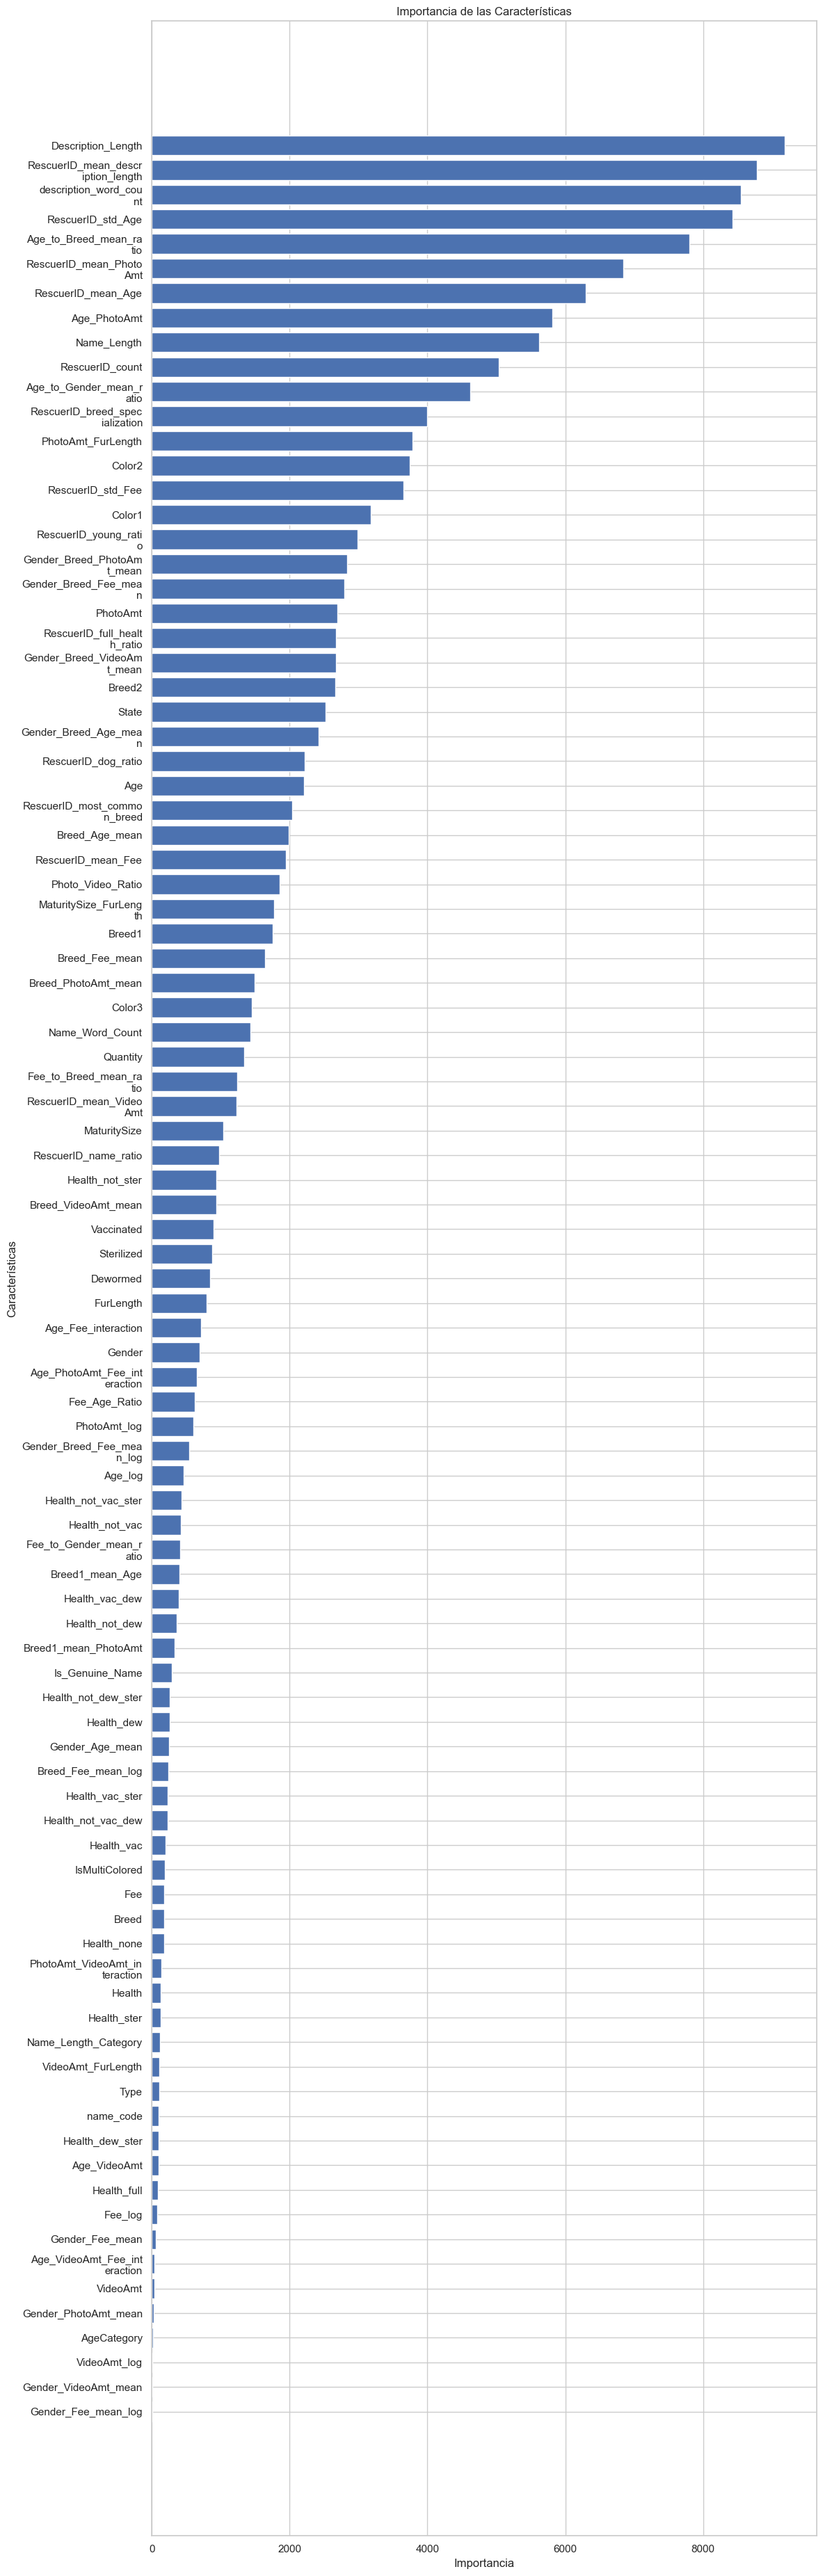

In [156]:

# Configurar visualizaciones
sns.set(style="whitegrid")
# Obtener la importancia de las características
importance = lgb_model.feature_importance(importance_type='gain')
feature_names = X_train.columns

# Crear un DataFrame para mostrar las importancias
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})

# Ordenar el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Función para envolver el texto
def wrap_labels(label, max_width=20):
    return '\n'.join(textwrap.wrap(label, max_width))

# Aplicar la función de envoltura a las etiquetas de características
feature_importance_df['wrapped_feature'] = feature_importance_df['feature'].apply(wrap_labels)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, len(feature_importance_df) * 0.4))

# Crear el gráfico de barras horizontales
bars = ax.barh(feature_importance_df['wrapped_feature'], feature_importance_df['importance'])

# Configurar el título y las etiquetas
ax.set_title('Importancia de las Características')
ax.set_xlabel('Importancia')
ax.set_ylabel('Características')

# Ajustar el espacio entre las etiquetas del eje y
plt.subplots_adjust(left=0.3)

# Invertir el orden del eje y para que la característica más importante esté arriba
ax.invert_yaxis()

# Ajustar los márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Predecir en archivo test.csv
Podemos ahora utilizar el archivo de test para validar el modelo y preparar una prediccion para utilizar en la competencia de Kaggle

In [1]:
# PATH_TO_TEST = "...." #Definir...

# df_test = pd.read_csv(PATH_TO_TEST)
# #df_test.head()

# #FEATURE ENGINEERING
# #Nuevas variables 
# dataset=feature_engineering(df_test)

# #predict
# df_predict_test=lgb_model.predict(dataset[features]).argmax(axis=1)

# # check distribucion
# pd.Series(df_predict_test).value_counts(normalize=True)

# # Guardar predicciones en un archivo CSV
# dataset['AdoptionSpeed'] = df_predict_test

# # Guardar el archivo CSV para la competencia de Kaggle
# dataset[['PetID', 'AdoptionSpeed']].to_csv('submission.csv', index=False)


## Modelo con cross validation y conjunto de test

In [41]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(),dy_pred.argmax(axis=1),weights = 'quadratic')
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_lgb_objective(trial):

    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        #Hiperparametros a optimizar utilizando suggest_float o suggest_int segun el tipo de dato
                        #Se indica el nombre del parametro, valor minimo, valor maximo 
                        #en elgunos casos el parametro log=True para parametros que requieren buscar en esa escala
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        #Dataset in fold (donde entreno) 
        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                        label=y_train.iloc[if_index],
                                        free_raw_data=False)
        
        #Dataset Out of fold (donde mido la performance del CV)
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                        label=y_train.iloc[oof_index],
                                        free_raw_data=False)

        #Entreno el modelo
        lgb_model = lgb.train(lgb_params,
                                lgb_if_dataset,
                                valid_sets=lgb_oof_dataset,
                                callbacks=[lgb.early_stopping(10, verbose=False)],
                                feval = lgb_custom_metric_kappa
                                )
        
        #Acumulo los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        #Se predice el 20% de los datos que separe para tes y no uso para entrenar en ningun fold
        scores_ensemble = scores_ensemble + lgb_model.predict(X_test)
        
        #Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds = score_folds + cohen_kappa_score(y_train.iloc[oof_index], 
                                                            lgb_model.predict(X_train.iloc[oof_index]).argmax(axis=1),weights = 'quadratic')/n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = cohen_kappa_score(y_test,scores_ensemble.argmax(axis=1),weights = 'quadratic')
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [42]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///../work/db.sqlite3",  # Specify the storage URL here.
                            study_name="04 - LGB Multiclass - FE v3", #nombre del experimento
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_lgb_objective, n_trials=100)

<ipython-input-42-3ba8469af45f>:2: ExperimentalWarning:

FileSystemArtifactStore is experimental (supported from v3.3.0). The interface can change in the future.

[I 2024-09-14 12:14:58,409] Using an existing study with name '04 - LGB Multiclass CV' instead of creating a new one.
<ipython-input-41-1c6539846d38>:86: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

<ipython-input-41-1c6539846d38>:94: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

[I 2024-09-14 12:15:22,817] Trial 671 finished with value: 0.37184665533691497 and parameters: {'lambda_l1': 0.5388084648637167, 'lambda_l2': 1.2860602375541024, 'num_leaves': 6, 'feature_fraction': 0.41325944952074783, 'bagging_fraction': 0.43724914537542203, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 45 with value: 1.0.
<ipython-input-41-1c6539846d38>:86: ExperimentalWarning:

upload_ar

KeyboardInterrupt: 